In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [2]:
df_train = pd.read_csv('data/Train/Train.csv', header=0)
df_camps = pd.read_csv('data/Train/Health_Camp_Detail.csv', header=0)
df_patients = pd.read_csv('data/Train/Patient_Profile.csv', header=0)

df_first_camp = pd.read_csv('data/Train/First_Health_Camp_Attended.csv', header=0)
df_second_camp = pd.read_csv('data/Train/Second_Health_Camp_Attended.csv', header=0)
df_third_camp = pd.read_csv('data/Train/Third_Health_Camp_Attended.csv', header=0)

df_test = pd.read_csv('data/test.csv', header=0)
submission = pd.read_csv('data/sample_submission.csv', header=0)

In [3]:
df_train.shape, df_camps.shape, df_patients.shape, df_first_camp.shape, df_second_camp.shape, df_third_camp.shape, df_test.shape, submission.shape

((75278, 8),
 (65, 6),
 (37633, 11),
 (6218, 5),
 (7819, 3),
 (6515, 4),
 (35249, 8),
 (35249, 3))

In [4]:
df_train.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,489652,6578,10-Sep-05,4,0,0,0,2
1,507246,6578,18-Aug-05,45,5,0,0,7
2,523729,6534,29-Apr-06,0,0,0,0,0
3,524931,6535,07-Feb-04,0,0,0,0,0
4,521364,6529,28-Feb-06,15,1,0,0,7


In [5]:
df_test.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,505701,6548,21-May-06,1,0,0,0,2
1,500633,6584,02-Jun-06,0,0,0,0,0
2,506945,6582,10-Aug-06,0,0,0,0,0
3,497447,6551,27-Aug-06,0,0,0,0,0
4,496446,6533,19-Sep-06,0,0,0,0,0


In [6]:
df_camps.head()

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2
2,6544,03-Nov-03,15-Nov-03,First,F,1
3,6585,22-Nov-03,05-Dec-03,First,E,2
4,6561,30-Nov-03,18-Dec-03,First,E,1


In [7]:
df_patients.head()

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1,90,39,18-Jun-03,NaN,Software Industry
1,507733,0,0,0,0,1,None,40,20-Jul-03,H,Software Industry
2,508307,0,0,0,0,3,87,46,02-Nov-02,D,BFSI
3,512612,0,0,0,0,1,75,47,02-Nov-02,D,Education
4,521075,0,0,0,0,3,None,80,24-Nov-02,H,Others


In [8]:
submission.head()

,Patient_ID,Health_Camp_ID,Outcome
0,505701,6548,0.5
1,500633,6584,0.5
2,506945,6582,0.5
3,497447,6551,0.5
4,496446,6533,0.5


In [9]:
df_first_camp.head()

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
0,506181,6560,40,0.439024,NaN
1,494977,6560,20,0.097561,NaN
2,518680,6560,10,0.048780,NaN
3,509916,6560,30,0.634146,NaN
4,488006,6560,20,0.024390,NaN


In [10]:
df_second_camp.head()

,Patient_ID,Health_Camp_ID,Health Score
0,526631,6536,0.875136
1,509122,6536,0.755700
2,498864,6536,0.673181
3,515398,6536,0.722041
4,504624,6536,0.464712


In [11]:
df_third_camp.head()

,Patient_ID,Health_Camp_ID,Number_of_stall_visited,Last_Stall_Visited_Number
0,517875,6527,3,1
1,504692,6578,1,1
2,504692,6527,3,1
3,493167,6527,4,4
4,510954,6528,2,2


In [12]:
pd.merge(df_first_camp[['Patient_ID']], df_second_camp[['Patient_ID']], on='Patient_ID').shape

(5212, 1)

In [13]:
df_first_camp.shape, df_second_camp.shape, df_third_camp.shape

((6218, 5), (7819, 3), (6515, 4))

In [14]:
min(df_first_camp.Health_Score), max(df_first_camp.Health_Score), min(df_second_camp['Health Score']), max(df_second_camp['Health Score']), min(df_third_camp.Number_of_stall_visited), max(df_third_camp.Number_of_stall_visited)

(0.0016666670000000001, 1.0, 0.058992805999999995, 1.0, 0, 7)

In [15]:
df_first_camp['label'] = df_first_camp['Health_Score'].apply(lambda x: 1 if x > 0 else 0)
df_second_camp['label'] = df_second_camp['Health Score'].apply(lambda x: 1 if x > 0 else 0)
df_third_camp['label'] = df_third_camp['Number_of_stall_visited'].apply(lambda x: 1 if x > 0 else 0)

df_label = pd.concat((df_first_camp[['Patient_ID', 'Health_Camp_ID', 'label']], df_second_camp[['Patient_ID', 'Health_Camp_ID', 'label']], df_third_camp[['Patient_ID', 'Health_Camp_ID', 'label']]))

print(df_first_camp.shape, df_second_camp.shape, df_third_camp.shape, df_label.shape)
assert df_first_camp.shape[0] + df_second_camp.shape[0] + df_third_camp.shape[0] == df_label.shape[0]

(6218, 6) (7819, 4) (6515, 5) (20552, 3)


In [16]:
df_train = pd.merge(df_train, df_camps, on=['Health_Camp_ID'], how='left')
df_train = pd.merge(df_train, df_patients, on=['Patient_ID'], how='left')

# df_train = pd.merge(df_train, df_first_camp, on=['Patient_ID', 'Health_Camp_ID'], how='left')
# df_train = pd.merge(df_train, df_second_camp, on=['Patient_ID', 'Health_Camp_ID'], how='left')
# df_train = pd.merge(df_train, df_third_camp, on=['Patient_ID', 'Health_Camp_ID'], how='left')
df_train = pd.merge(df_train, df_label, on=['Patient_ID', 'Health_Camp_ID'], how='left')
df_train['label'] = df_train['label'].fillna(0)

In [17]:
df_test = pd.merge(df_test, df_camps, on=['Health_Camp_ID'], how='left')
df_test = pd.merge(df_test, df_patients, on=['Patient_ID'], how='left')

In [18]:
df_train.shape, df_test.shape

((75278, 24), (35249, 23))

In [19]:
df_train.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,...,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,label
0,489652,6578,10-Sep-05,4,0,0,0,2,16-Aug-05,14-Oct-05,...,0,0,0,None,None,None,06-Dec-04,NaN,NaN,1.0
1,507246,6578,18-Aug-05,45,5,0,0,7,16-Aug-05,14-Oct-05,...,0,0,0,1,75,40,08-Sep-04,C,Others,0.0
2,523729,6534,29-Apr-06,0,0,0,0,0,17-Oct-05,07-Nov-07,...,0,0,0,None,None,None,22-Jun-04,NaN,NaN,1.0
3,524931,6535,07-Feb-04,0,0,0,0,0,01-Feb-04,18-Feb-04,...,0,0,0,None,None,None,07-Feb-04,I,NaN,0.0
4,521364,6529,28-Feb-06,15,1,0,0,7,30-Mar-06,03-Apr-06,...,0,0,1,1,70,40,04-Jul-03,I,Technology,1.0


In [20]:
df_test.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,...,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,505701,6548,21-May-06,1,0,0,0,2,13-Jun-06,18-Aug-06,...,0,0,0,0,0,None,44,05-Feb-03,E,NaN
1,500633,6584,02-Jun-06,0,0,0,0,0,04-Aug-06,09-Aug-06,...,0,1,0,0,1,67,41,11-Dec-04,D,Consulting
2,506945,6582,10-Aug-06,0,0,0,0,0,06-Apr-06,07-Nov-07,...,0,0,0,0,None,None,None,19-Apr-06,NaN,NaN
3,497447,6551,27-Aug-06,0,0,0,0,0,13-Nov-06,18-Nov-06,...,0,0,0,0,0,None,47,25-Aug-06,B,NaN
4,496446,6533,19-Sep-06,0,0,0,0,0,20-Sep-06,23-Sep-06,...,0,0,0,0,None,None,None,19-Sep-06,B,NaN


In [21]:
df_train['label'].value_counts()

0.0    54744
1.0    20534
Name: label, dtype: int64

In [22]:
df_train.dtypes, df_test.dtypes

(Patient_ID             int64
 Health_Camp_ID         int64
 Registration_Date     object
 Var1                   int64
 Var2                   int64
 Var3                   int64
 Var4                   int64
 Var5                   int64
 Camp_Start_Date       object
 Camp_End_Date         object
 Category1             object
 Category2             object
 Category3              int64
 Online_Follower        int64
 LinkedIn_Shared        int64
 Twitter_Shared         int64
 Facebook_Shared        int64
 Income                object
 Education_Score       object
 Age                   object
 First_Interaction     object
 City_Type             object
 Employer_Category     object
 label                float64
 dtype: object,
 Patient_ID            int64
 Health_Camp_ID        int64
 Registration_Date    object
 Var1                  int64
 Var2                  int64
 Var3                  int64
 Var4                  int64
 Var5                  int64
 Camp_Start_Date      object
 Ca

In [23]:
df_train.apply(lambda x: sum(pd.isna(x)), axis=0)

Patient_ID               0
Health_Camp_ID           0
Registration_Date      334
Var1                     0
Var2                     0
Var3                     0
Var4                     0
Var5                     0
Camp_Start_Date          0
Camp_End_Date            0
Category1                0
Category2                0
Category3                0
Online_Follower          0
LinkedIn_Shared          0
Twitter_Shared           0
Facebook_Shared          0
Income                   0
Education_Score          0
Age                      0
First_Interaction        0
City_Type            33208
Employer_Category    60075
label                    0
dtype: int64

In [24]:
df_train.Income.value_counts(), df_train.Education_Score.value_counts(), df_train.Age.value_counts(), df_train.First_Interaction.value_counts(), df_train.City_Type.value_counts(), df_train.Employer_Category.value_counts()

(None    53546
 0        8393
 1        5346
 2        4108
 3        2155
 4        1034
 5         440
 6         256
 Name: Income, dtype: int64,
 None           65345
 82               468
 79               423
 75               413
 86               390
                ...  
 88.07666667        1
 83.8125            1
 84.735             1
 83.5               1
 83.5075            1
 Name: Education_Score, Length: 228, dtype: int64,
 None    51612
 41       1843
 40       1760
 42       1676
 43       1628
 39       1477
 44       1460
 45       1094
 37       1033
 46       1025
 38        996
 47        885
 72        792
 48        736
 73        710
 49        644
 71        593
 74        540
 36        477
 50        446
 52        418
 51        416
 70        394
 35        360
 53        315
 54        222
 34        191
 56        189
 75        167
 55        147
 76        131
 69        118
 58        111
 59         88
 67         87
 33         68
 57         68
 77

In [25]:
# np.median(df_train.loc[pd.notna(df_train['Income']), 'Income'])

In [26]:
df_train['Income'] = df_train['Income'].apply(lambda x: np.nan if x == 'None' else x).astype('float')
df_test['Income'] = df_test['Income'].apply(lambda x: np.nan if x == 'None' else x).astype('float')

df_train['Education_Score'] = df_train['Education_Score'].apply(lambda x: np.nan if x == 'None' else x).astype('float')
df_test['Education_Score'] = df_test['Education_Score'].apply(lambda x: np.nan if x == 'None' else x).astype('float')

df_train['Age'] = df_train['Age'].apply(lambda x: np.nan if x == 'None' else x).astype('float')
df_test['Age'] = df_test['Age'].apply(lambda x: np.nan if x == 'None' else x).astype('float')

In [27]:
le_Category1, le_Category2, le_City_Type, le_Employer_Category = preprocessing.LabelEncoder(), preprocessing.LabelEncoder(), preprocessing.LabelEncoder(), preprocessing.LabelEncoder()

In [28]:
le_Category1.fit(df_train.loc[pd.notna(df_train['Category1']), 'Category1'])
le_Category2.fit(df_train.loc[pd.notna(df_train['Category2']), 'Category2'])
le_City_Type.fit(df_train.loc[pd.notna(df_train['City_Type']), 'City_Type'])
le_Employer_Category.fit(df_train.loc[pd.notna(df_train['Employer_Category']), 'Employer_Category'])

LabelEncoder()

In [29]:
missing_impute = -999

In [30]:
df_train['Category1'] = df_train['Category1'].apply(lambda x: missing_impute if pd.isna(x) else le_Category1.transform([x])[0])
df_train['Category2'] = df_train['Category2'].apply(lambda x: missing_impute if pd.isna(x) else le_Category2.transform([x])[0])
df_train['City_Type'] = df_train['City_Type'].apply(lambda x: missing_impute if pd.isna(x) else le_City_Type.transform([x])[0])
df_train['Employer_Category'] = df_train['Employer_Category'].apply(lambda x: missing_impute if pd.isna(x) else le_Employer_Category.transform([x])[0])

In [31]:
df_test['Category1'] = df_test['Category1'].apply(lambda x: missing_impute if pd.isna(x) else le_Category1.transform([x])[0])
df_test['Category2'] = df_test['Category2'].apply(lambda x: missing_impute if pd.isna(x) else le_Category2.transform([x])[0])
df_test['City_Type'] = df_test['City_Type'].apply(lambda x: missing_impute if pd.isna(x) else le_City_Type.transform([x])[0])
df_test['Employer_Category'] = df_test['Employer_Category'].apply(lambda x: missing_impute if pd.isna(x) else le_Employer_Category.transform([x])[0])

In [32]:
#dates
# Registration_Date, Camp_Start_Date, Camp_End_Date, First_Interaction

df_train['Registration_Date'] = pd.to_datetime(df_train['Registration_Date'], format='%d-%b-%y')
df_train['Camp_Start_Date'] = pd.to_datetime(df_train['Camp_Start_Date'], format='%d-%b-%y')
df_train['Camp_End_Date'] = pd.to_datetime(df_train['Camp_End_Date'], format='%d-%b-%y')
df_train['First_Interaction'] = pd.to_datetime(df_train['First_Interaction'], format='%d-%b-%y')

df_test['Registration_Date'] = pd.to_datetime(df_test['Registration_Date'], format='%d-%b-%y')
df_test['Camp_Start_Date'] = pd.to_datetime(df_test['Camp_Start_Date'], format='%d-%b-%y')
df_test['Camp_End_Date'] = pd.to_datetime(df_test['Camp_End_Date'], format='%d-%b-%y')
df_test['First_Interaction'] = pd.to_datetime(df_test['First_Interaction'], format='%d-%b-%y')

In [33]:
df_train['Registration_weekday'] = df_train['Registration_Date'].apply(lambda x: x.weekday())
df_train['Registration_weekofyear'] = df_train['Registration_Date'].apply(lambda x: x.weekofyear)
df_train['Registration_month'] = df_train['Registration_Date'].apply(lambda x: x.month)
df_train['Registration_quarter'] = df_train['Registration_Date'].apply(lambda x: x.quarter)
df_train['Registration_year'] = df_train['Registration_Date'].apply(lambda x: x.year)

df_test['Registration_weekday'] = df_test['Registration_Date'].apply(lambda x: x.weekday())
df_test['Registration_weekofyear'] = df_test['Registration_Date'].apply(lambda x: x.weekofyear)
df_test['Registration_month'] = df_test['Registration_Date'].apply(lambda x: x.month)
df_test['Registration_quarter'] = df_test['Registration_Date'].apply(lambda x: x.quarter)
df_test['Registration_year'] = df_test['Registration_Date'].apply(lambda x: x.year)



df_train['Camp_Start_Date_weekday'] = df_train['Camp_Start_Date'].apply(lambda x: x.weekday())
df_train['Camp_Start_Date_weekofyear'] = df_train['Camp_Start_Date'].apply(lambda x: x.weekofyear)
df_train['Camp_Start_Date_month'] = df_train['Camp_Start_Date'].apply(lambda x: x.month)
df_train['Camp_Start_Date_quarter'] = df_train['Camp_Start_Date'].apply(lambda x: x.quarter)
df_train['Camp_Start_Date_year'] = df_train['Camp_Start_Date'].apply(lambda x: x.year)

df_test['Camp_Start_Date_weekday'] = df_test['Camp_Start_Date'].apply(lambda x: x.weekday())
df_test['Camp_Start_Date_weekofyear'] = df_test['Camp_Start_Date'].apply(lambda x: x.weekofyear)
df_test['Camp_Start_Date_month'] = df_test['Camp_Start_Date'].apply(lambda x: x.month)
df_test['Camp_Start_Date_quarter'] = df_test['Camp_Start_Date'].apply(lambda x: x.quarter)
df_test['Camp_Start_Date_year'] = df_test['Camp_Start_Date'].apply(lambda x: x.year)



df_train['Camp_End_Date_weekday'] = df_train['Camp_End_Date'].apply(lambda x: x.weekday())
df_train['Camp_End_Date_weekofyear'] = df_train['Camp_End_Date'].apply(lambda x: x.weekofyear)
df_train['Camp_End_Date_month'] = df_train['Camp_End_Date'].apply(lambda x: x.month)
df_train['Camp_End_Date_quarter'] = df_train['Camp_End_Date'].apply(lambda x: x.quarter)
df_train['Camp_End_Date_year'] = df_train['Camp_End_Date'].apply(lambda x: x.year)

df_test['Camp_End_Date_weekday'] = df_test['Camp_End_Date'].apply(lambda x: x.weekday())
df_test['Camp_End_Date_weekofyear'] = df_test['Camp_End_Date'].apply(lambda x: x.weekofyear)
df_test['Camp_End_Date_month'] = df_test['Camp_End_Date'].apply(lambda x: x.month)
df_test['Camp_End_Date_quarter'] = df_test['Camp_End_Date'].apply(lambda x: x.quarter)
df_test['Camp_End_Date_year'] = df_test['Camp_End_Date'].apply(lambda x: x.year)



df_train['First_Interaction_weekday'] = df_train['First_Interaction'].apply(lambda x: x.weekday())
df_train['First_Interaction_weekofyear'] = df_train['First_Interaction'].apply(lambda x: x.weekofyear)
df_train['First_Interaction_month'] = df_train['First_Interaction'].apply(lambda x: x.month)
df_train['First_Interaction_quarter'] = df_train['First_Interaction'].apply(lambda x: x.quarter)
df_train['First_Interaction_year'] = df_train['First_Interaction'].apply(lambda x: x.year)

df_test['First_Interaction_weekday'] = df_test['First_Interaction'].apply(lambda x: x.weekday())
df_test['First_Interaction_weekofyear'] = df_test['First_Interaction'].apply(lambda x: x.weekofyear)
df_test['First_Interaction_month'] = df_test['First_Interaction'].apply(lambda x: x.month)
df_test['First_Interaction_quarter'] = df_test['First_Interaction'].apply(lambda x: x.quarter)
df_test['First_Interaction_year'] = df_test['First_Interaction'].apply(lambda x: x.year)

In [34]:
df_train['interation_to_registration'] = (df_train['Registration_Date'] - df_train['First_Interaction']).apply(lambda x: x.days)
df_train['camp_duration'] = (df_train['Camp_End_Date'] - df_train['Camp_Start_Date']).apply(lambda x: x.days)
df_train['camp_weeks'] = df_train['camp_duration']/7
df_train['registration_to_camp_start'] = (df_train['Camp_Start_Date'] - df_train['Registration_Date']).apply(lambda x: x.days)


df_test['interation_to_registration'] = (df_test['Registration_Date'] - df_test['First_Interaction']).apply(lambda x: x.days)
df_test['camp_duration'] = (df_test['Camp_End_Date'] - df_test['Camp_Start_Date']).apply(lambda x: x.days)
df_test['camp_weeks'] = df_test['camp_duration']/7
df_test['registration_to_camp_start'] = (df_test['Camp_Start_Date'] - df_test['Registration_Date']).apply(lambda x: x.days)

In [35]:
df_train.columns, df_test.columns

(Index(['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2',
        'Var3', 'Var4', 'Var5', 'Camp_Start_Date', 'Camp_End_Date', 'Category1',
        'Category2', 'Category3', 'Online_Follower', 'LinkedIn_Shared',
        'Twitter_Shared', 'Facebook_Shared', 'Income', 'Education_Score', 'Age',
        'First_Interaction', 'City_Type', 'Employer_Category', 'label',
        'Registration_weekday', 'Registration_weekofyear', 'Registration_month',
        'Registration_quarter', 'Registration_year', 'Camp_Start_Date_weekday',
        'Camp_Start_Date_weekofyear', 'Camp_Start_Date_month',
        'Camp_Start_Date_quarter', 'Camp_Start_Date_year',
        'Camp_End_Date_weekday', 'Camp_End_Date_weekofyear',
        'Camp_End_Date_month', 'Camp_End_Date_quarter', 'Camp_End_Date_year',
        'First_Interaction_weekday', 'First_Interaction_weekofyear',
        'First_Interaction_month', 'First_Interaction_quarter',
        'First_Interaction_year', 'interation_to_registration'

In [36]:
df_train['train_data'] = 1
df_test['train_data'] = 0

df_train_test = pd.concat((df_train, df_test))
df_train_test = df_train_test.sort_values(['Patient_ID', 'Camp_Start_Date'])

print(df_train.shape, df_test.shape, df_train_test.shape)
df_train_test['attended_before'] = df_train_test.sort_values(['Patient_ID', 'Camp_Start_Date']).groupby(['Patient_ID'])['label'].shift().rolling(365, min_periods=1).sum().fillna(0).values
df_train_test['attended_before_flag'] = df_train_test['attended_before'].apply(lambda x: 1 if x > 0 else 0)

df_train, df_test = df_train_test[df_train_test.train_data == 1], df_train_test[df_train_test.train_data == 0]

del df_train_test

(75278, 49) (35249, 48) (110527, 49)


In [37]:
cat_cols = ['Category1', 'Category2', 'Category3', 'City_Type', 'Employer_Category']
feature_cols = ['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Category1', 'Category2', 'Category3', 'Online_Follower', 'LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'Income', 'Education_Score', 'Age', 'City_Type', 'Employer_Category', 'Registration_weekday', 'Registration_weekofyear', 'Registration_month',
        'Registration_quarter', 'Registration_year', 'Camp_Start_Date_weekday',
        'Camp_Start_Date_weekofyear', 'Camp_Start_Date_month',
        'Camp_Start_Date_quarter', 'Camp_Start_Date_year',
        'Camp_End_Date_weekday', 'Camp_End_Date_weekofyear',
        'Camp_End_Date_month', 'Camp_End_Date_quarter', 'Camp_End_Date_year',
        'First_Interaction_weekday', 'First_Interaction_weekofyear',
        'First_Interaction_month', 'First_Interaction_quarter',
        'First_Interaction_year', 'interation_to_registration', 'camp_duration',
        'camp_weeks', 'registration_to_camp_start', 'attended_before', 'attended_before_flag']
label_col = 'label'

In [38]:
stratify_var = [str(x1) + '_' + str(x2) for (x1, x2) in zip(df_train['Category1'], df_train['label'])]

df_train, df_eval = train_test_split(df_train, test_size=0.25, random_state=42, shuffle=True, stratify=stratify_var)
# df_train, df_eval = train_test_split(df_train, test_size=0.25, random_state=42, shuffle=True, stratify=df_train['Category1'])

In [39]:
df_train.shape, df_eval.shape

((56458, 51), (18820, 51))

In [40]:
params = {'learning_rate': 0.014342949214139759, 'max_depth': 9, 'min_data_in_leaf': 479, 'n_estimators': 846, 'num_leaves': 350}

In [41]:
params['n_estimators'] = int(params['n_estimators'])
params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
params['max_depth'] = int(params['max_depth'])
params['num_leaves'] = int(params['num_leaves'])
params['objective'] = 'binary:logistic'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['colsample_bytree'] = 0.7

In [42]:
df_train = pd.concat((df_train, df_eval))

In [43]:
clf = xgb.XGBClassifier(**params)

clf.fit(df_train[feature_cols], df_train[label_col], eval_metric='auc', verbose=True)

eval_score_auc = roc_auc_score(df_train[label_col], clf.predict(df_train[feature_cols]))
eval_score_acc = accuracy_score(df_train[label_col], clf.predict(df_train[feature_cols]))

print('AUC: {}, ACC: {}'.format(eval_score_auc, eval_score_acc))

[21:14:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { boosting_type, min_data_in_leaf, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


AUC: 0.8296145471443653, ACC: 0.8829804192459948


In [44]:
# preds = clf.predict(df_test[feature_cols])

In [45]:
preds = clf.predict_proba(df_test[feature_cols])
preds = preds[:, 1]

In [46]:
# Patient_ID	Health_Camp_ID	Outcome

In [47]:
submission = pd.DataFrame({'Patient_ID':df_test['Patient_ID'], 'Health_Camp_ID':df_test['Health_Camp_ID'], 'Outcome':preds})

In [48]:
submission.to_csv('xgb_baseline.csv', index=None)

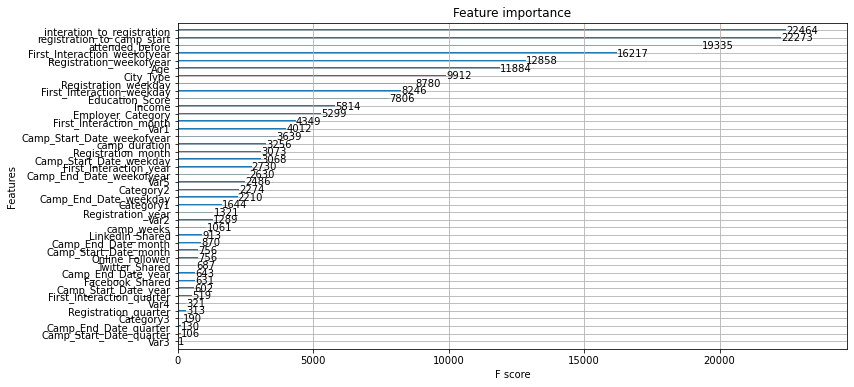

In [49]:
plt.rcParams['figure.figsize'] = (12, 6)
xgb.plot_importance(clf)
plt.show()